In [1]:
import keras.backend as K

from keras import Sequential, regularizers
from keras.models import load_model
from keras.layers import Dense
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import os
import pickle
import scipy.sparse as sp

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# draw loss curve
def draw_curve(data1, label1, data2, label2, base1, base2):
    x = range(len(data1))
    plt.figure(figsize=(7.0, 4.0))
    plt.plot(x, data1, color='blue', label=label1)
    if data2:
        plt.plot(x, data2, color='red', label=label2)
    if base1 and base2:
        left, right = plt.xlim()
        plt.hlines(y=base1, xmin=left, xmax=right, color='gray', linestyles='dashed')
        plt.hlines(y=base2, xmin=left, xmax=right, color='darkgray', linestyles='dashed')
    plt.legend()
    plt.xticks(x)
    plt.ylabel('score')
    plt.xlabel('epoches')
    plt.show()

# Create Dataset

In [3]:
# iterate all files
def read_file(pos_path, neg_path):
    for path in [pos_path, neg_path]:
        for dirpath, dirnames, filenames in os.walk(path):
            for filename in filenames:
#                 print(os.path.join(dirpath,filename))
                yield open(os.path.join(dirpath,filename), 'r', errors='ignore', encoding='utf').read()

In [4]:
# create training data from files
def get_train_samples(pos_path, neg_path):
    # create input_X
    vectorizer = TfidfVectorizer(min_df=0, lowercase=False)
    f = read_file(pos_path, neg_path)
    input_X = vectorizer.fit_transform(f)
#     print(vectorizer.vocabulary_)
    # save the transformer
    with open('tf_idf_transformer.pkl', 'wb') as fw:
        pickle.dump(vectorizer, fw)
        print('TF-IDF Transformer saved. vocabulary size =', len(vectorizer.vocabulary_))
    # create output_y
    output_y = [1] * len([filenames for _,_,filenames in os.walk(pos_path)][0]) + [0] * len([filenames for _,_,filenames in os.walk(neg_path)][0])
    assert input_X.shape[0] == len(output_y)
    # split the data into train and val
    return train_test_split(input_X, output_y, test_size=0.1, random_state=23)

In [5]:
# create test data from files
def get_test_samples(pos_path, neg_path):
    # create X_test
    vectorizer = pickle.load(open('tf_idf_transformer.pkl', 'rb'))
    f = read_file(pos_path, neg_path)
    X_test = vectorizer.transform(f)
    # create y_test
    y_test = [1] * len([filenames for _,_,filenames in os.walk(pos_path)][0]) + [0] * len([filenames for _,_,filenames in os.walk(neg_path)][0])
    assert X_test.shape[0] == len(y_test)
    return X_test, y_test

In [6]:
X_train, X_val, y_train, y_val = get_train_samples('./aclImdb/train/pos', './aclImdb/train/neg')

TF-IDF Transformer saved. vocabulary size = 94112


In [7]:
X_train

<22500x94112 sparse matrix of type '<class 'numpy.float64'>'
	with 3217190 stored elements in Compressed Sparse Row format>

In [8]:
len(y_train)

22500

In [9]:
X_val

<2500x94112 sparse matrix of type '<class 'numpy.float64'>'
	with 354884 stored elements in Compressed Sparse Row format>

In [10]:
len(y_val)

2500

# Training

In [11]:
def get_mlp_model(input_dim, neural_dim):
    model = Sequential()
    model.add(Dense(neural_dim, 
                    input_dim=input_dim,
                    kernel_regularizer=regularizers.l2(0.001), # set l2 regularizers to prevent over-fitting
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [12]:
# iterate training samples
def sample_generator(input_x, output_y, batch_size):
    num_batches = int(np.ceil(input_x.shape[0] / batch_size))
    sample_index = np.arange(input_x.shape[0])
    
    is_sparse = sp.issparse(input_x)
    
    np.random.shuffle(sample_index)
    k = 0
    while True:
        batch_index = sample_index[batch_size * k:batch_size * (k + 1)]
        if is_sparse:
            x_batch = input_x[batch_index, :].toarray()
        else:
            x_batch = input_x[batch_index, :]
        y_batch = output_y[batch_index]
        k += 1
        yield x_batch, y_batch
        if k == num_batches:
            np.random.shuffle(sample_index)
            k = 0

In [13]:
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

In [14]:
def train_model(X_train, X_val, y_train, y_val, neural_dim=16, epochs=10, batch_size=32):
    model = get_mlp_model(X_train.shape[1], neural_dim)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', fbeta_score])
    
    fit_steps = int(np.ceil(X_train.shape[0] / batch_size))
    hist = model.fit_generator(generator=sample_generator(X_train, np.array(y_train), batch_size),
                               steps_per_epoch=fit_steps,
                               epochs=epochs,
                               validation_data=(X_val, y_val),
                               verbose=True)
    
    return model, hist

In [15]:
model, hist = train_model(X_train, X_val, y_train, y_val, neural_dim=16)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
704/704 [==============================] - 9s 13ms/step - loss: 0.5969 - acc: 0.8226 - fbeta_score: 0.7871 - val_loss: 0.5234 - val_acc: 0.8660 - val_fbeta_score: 0.7740
Epoch 2/10
704/704 [==============================] - 8s 11ms/step - loss: 0.4956 - acc: 0.8768 - fbeta_score: 0.8741 - val_loss: 0.4718 - val_acc: 0.8796 - val_fbeta_score: 0.7946
Epoch 3/10
704/704 [==============================] - 8s 11ms/step - loss: 0.4571 - acc: 0.8884 - fbeta_score: 0.8866 - val_loss: 0.4576 - val_acc: 0.8864 - val_fbeta_score: 0.7849
Epoch 4/10
704/704 [==============================] - 8s 12ms/step - loss: 0.4338 - acc: 0.8957 - fbeta_score: 0.8936 - val_loss: 0.4397 - val_acc: 0.8828 - val_fbeta_score: 0.8088
Epoch 5/10
704/704 [==============================] - 8s 11ms/step - loss: 0.4157 - acc: 0.9045 - fbeta_score: 0.9018 - val_loss: 0.4243 - val_acc: 0.8944 -

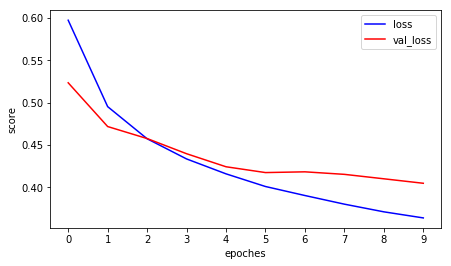

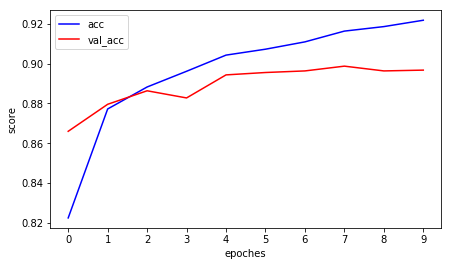

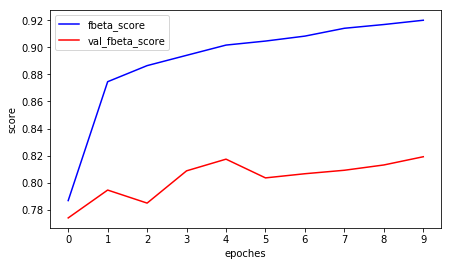

In [16]:
draw_curve(hist.history['loss'], 'loss', hist.history['val_loss'], 'val_loss', None, None)
draw_curve(hist.history['acc'], 'acc', hist.history['val_acc'], 'val_acc', None, None)
draw_curve(hist.history['fbeta_score'], 'fbeta_score', hist.history['val_fbeta_score'], 'val_fbeta_score', None, None)

In [17]:
model.summary()
model.save('collateral_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                1505808   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 1,505,825
Trainable params: 1,505,825
Non-trainable params: 0
_________________________________________________________________


# Prediction

In [18]:
X_test, y_test = get_test_samples('./aclImdb/test/pos', './aclImdb/test/neg')

In [19]:
X_test

<25000x94112 sparse matrix of type '<class 'numpy.float64'>'
	with 3450832 stored elements in Compressed Sparse Row format>

In [20]:
len(y_test)

25000

In [21]:
model = load_model('collateral_model.h5', compile=False)
y_predict = model.predict_classes(X_test)

In [22]:
y_predict = y_predict.ravel()
y_test = np.array(y_test)

In [23]:
test_accuracy = sum(y_predict == y_test) / len(y_test)
hit = sum(y_predict & y_test)
test_precision = hit / sum(y_predict)
test_recall = hit / sum(y_test)
test_f1 = 2 * test_precision * test_recall / (test_precision + test_recall)
print('test_accuracy =', test_accuracy)
print('test_precision =', test_precision)
print('test_recall =', test_recall)
print('test_f1 =', test_f1)

test_accuracy = 0.87996
test_precision = 0.8772138829322532
test_recall = 0.8836
test_f1 = 0.8803953608863736
